# Deep Learning Aplicado a la Detección Automática de Valvulopatías Usando Sonidos Cardíacos
John Jairo Gelpud Chachinoy<sup>1</sup>, Silvia Gabriela Castillo Pastuzan<sup>2</sup>

Director: PhD. Wilson O. Achicanoy Martínez<sup>3</sup>

Coasesor: PhD(c). Mario Fernando Jojoa<sup>4</sup>

<sup>1</sup>Departamento de Electrónica, Universidad de Nariño, Pasto, e-mail: johnjairog@udenar.edu.co

<sup>2</sup>Departamento de Electrónica, Universidad de Nariño, Pasto, e-mail:gabrielacast@udenar.edu.co

<sup>3</sup>Departamento de Electrónica, Universidad de Nariño, Pasto, e-mail:wilachic@udenar.edu.co

<sup>4</sup>Universidad de Deusto, España, e-mail:mariojojoa@deusto.es


# Introducción
El presente código hace parte de los documentos desarrollados como parte del trabajo de tesis de grado para optar por el título de ingeniero electrónico en la Universidad de Nariño. ....

## Código de Inicialización

### Importar Librerías

In [1]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score
import scikitplot as skplt

plt.style.use('seaborn-white')
plt.rcParams.update({'font.size':18})

plt.ion()   # interactive mode

### Cargar Datos

#### ResNet152

In [2]:
path = 'ResNet152/'
res_num_ftrs = 2048
res_train_df = pd.read_excel(path+'train.xlsx', usecols=range(1, res_num_ftrs+2))
res_val_df = pd.read_excel(path+'val.xlsx', usecols=range(1, res_num_ftrs+2))
res_test_df = pd.read_excel(path+'test.xlsx', usecols=range(1, res_num_ftrs+2))

In [3]:
ftrs_columns = res_train_df.columns[:-1]
res_train_df = pd.concat([res_train_df, res_val_df], ignore_index=True)
scaler = MinMaxScaler()
scaler.fit(pd.concat([res_train_df[ftrs_columns], res_test_df[ftrs_columns]],
                      ignore_index=True))
res_train_df[ftrs_columns] = scaler.transform(res_train_df[ftrs_columns])
res_test_df[ftrs_columns] = scaler.transform(res_test_df[ftrs_columns])

In [4]:
print(res_train_df.info(), res_test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813 entries, 0 to 1812
Columns: 2049 entries, ftr_0 to label
dtypes: float64(2048), int64(1)
memory usage: 28.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Columns: 2049 entries, ftr_0 to label
dtypes: float64(2048), int64(1)
memory usage: 7.1 MB
None None


In [5]:
res_X_train = res_train_df.drop(['label'], axis=1).to_numpy()
res_y_train = res_train_df['label'].to_numpy()

In [6]:
res_X_test = res_test_df.drop(['label'], axis=1).to_numpy()
res_y_test = res_test_df['label'].to_numpy()

#### VGG16

In [7]:
path = 'VGG16/'
vgg_num_ftrs = 4096
vgg_train_df = pd.read_excel(path+'train.xlsx', usecols=range(1, vgg_num_ftrs+2))
vgg_val_df = pd.read_excel(path+'val.xlsx', usecols=range(1, vgg_num_ftrs+2))
vgg_test_df = pd.read_excel(path+'test.xlsx', usecols=range(1, vgg_num_ftrs+2))

In [8]:
ftrs_columns = vgg_train_df.columns[:-1]
scaler = MinMaxScaler()
vgg_train_df = pd.concat([vgg_train_df, vgg_val_df], ignore_index=True)
scaler.fit(pd.concat([vgg_train_df[ftrs_columns], vgg_test_df[ftrs_columns]],
                      ignore_index=True))
vgg_train_df[ftrs_columns] = scaler.transform(vgg_train_df[ftrs_columns])
vgg_test_df[ftrs_columns] = scaler.transform(vgg_test_df[ftrs_columns])

In [9]:
print(vgg_train_df.info(), vgg_test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813 entries, 0 to 1812
Columns: 4097 entries, ftr_0 to label
dtypes: float64(4096), int64(1)
memory usage: 56.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Columns: 4097 entries, ftr_0 to label
dtypes: float64(4096), int64(1)
memory usage: 14.2 MB
None None


In [10]:
vgg_X_train = vgg_train_df.drop(['label'], axis=1).to_numpy()
vgg_y_train = vgg_train_df['label'].to_numpy()

In [11]:
vgg_X_test = vgg_test_df.drop(['label'], axis=1).to_numpy()
vgg_y_test = vgg_test_df['label'].to_numpy()

## Entrenamiento de los modelos

In [12]:
def train_ML_model(model, X_train, y_train, K, params, scoring):
    cv = StratifiedKFold(n_splits=K, shuffle=True)
    grid = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring='accuracy',
                        refit=scoring, n_jobs=-1, verbose=4)
    start = time.time()
    grid_result = grid.fit(X_train, y_train)
    time_elapsed = time.time()-start
    print(f'Training complete in {time_elapsed//60}m {time_elapsed%60}s')
    print(f'Best {scoring}: {grid_result.best_score_}')
    print(f'Best model {grid_result.best_estimator_}')
    
    return grid_result.best_estimator_, scoring

### SVM

In [13]:
from sklearn import svm

C = np.logspace(-5, 15, 21, base=2)
kernel = ['rbf']
gamma = np.logspace(-15, 3, 19, base=2)
params = {'C':C, 'kernel':kernel, 'gamma':gamma}
K = 4
scoring = 'accuracy'

#### ResNet152

In [14]:
svm_clf = svm.SVC(kernel='rbf')
res_svm_clf, res_svm_acc = train_ML_model(svm_clf, res_X_train, res_y_train,
                                          K, params, scoring)

Fitting 4 folds for each of 399 candidates, totalling 1596 fits
Training complete in 28.0m 27.372681856155396s
Best accuracy: 0.875354951327907
Best model SVC(C=8.0, gamma=0.015625)


#### VGG16

In [15]:
svm_clf = svm.SVC(kernel='rbf')
vgg_svm_clf, vgg_svm_acc = train_ML_model(svm_clf, vgg_X_train, vgg_y_train,
                                          K, params, scoring)

Fitting 4 folds for each of 399 candidates, totalling 1596 fits
Training complete in 58.0m 15.715755701065063s
Best accuracy: 0.8576936915910571
Best model SVC(C=8.0, gamma=0.00390625)


### KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = np.arange(1, 200, 4)
weights = ['uniform', 'distance']
p = [1, 2]
params = {'n_neighbors':n_neighbors, 'weights':weights, 'p':p}

#### ResNet152

In [17]:
knn_clf = KNeighborsClassifier()
res_knn_clf, res_knn_acc = train_ML_model(knn_clf, res_X_train, res_y_train,
                                          K, params, scoring)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
Training complete in 2.0m 34.426902055740356s
Best accuracy: 0.8549270161721659
Best model KNeighborsClassifier(p=1)


#### VGG16

In [18]:
knn_clf = KNeighborsClassifier()
vgg_knn_clf, vgg_knn_acc = train_ML_model(knn_clf, vgg_X_train, vgg_y_train,
                                          K, params, scoring)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
Training complete in 5.0m 7.703512191772461s
Best accuracy: 0.8279081697153582
Best model KNeighborsClassifier(n_neighbors=9)


### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = np.arange(51, 500, 26)
max_features = ['sqrt', 'log2', None]
oob_score = [True]
params = {'n_estimators':n_estimators, 'max_features':max_features,
         'oob_score':oob_score}

#### ResNet152

In [20]:
rf_clf = RandomForestClassifier()
res_rf_clf, res_rf_acc = train_ML_model(rf_clf, res_X_train, res_y_train,
                                        K, params, scoring)

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Training complete in 75.0m 51.28771471977234s
Best accuracy: 0.8411434781340258
Best model RandomForestClassifier(max_features='sqrt', n_estimators=155, oob_score=True)


#### VGG16

In [21]:
rf_clf = RandomForestClassifier()
vgg_rf_clf, vgg_rf_acc = train_ML_model(rf_clf, vgg_X_train, vgg_y_train,
                                        K, params, scoring)

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Training complete in 61.0m 53.023128509521484s
Best accuracy: 0.8229497914053154
Best model RandomForestClassifier(max_features=None, n_estimators=389, oob_score=True)


## Evaluación de los modelos

In [22]:
def get_performance_measures(models, test_ftrs, test_labels, models_name):
    
    accuracy_scores = {models_name[0]:0, models_name[1]:0}
    sensitivity_scores = {models_name[0]:0, models_name[1]:0}
    specificity_scores = {models_name[0]:0, models_name[1]:0}
    precision_scores = {models_name[0]:0, models_name[1]:0}
    for model, model_name, X_test, y_test in zip(models, models_name, test_ftrs, test_labels):
        y_pred = model.predict(X_test)
        skplt.metrics.plot_confusion_matrix(y_test, y_pred, title=model_name,
                                        normalize=False)
        plt.show()
        accuracy_scores[model_name] = accuracy_score(y_test, y_pred)
        sensitivity_scores[model_name] = recall_score(y_test, y_pred, pos_label=0)
        specificity_scores[model_name] = recall_score(y_test, y_pred, pos_label=1)
        precision_scores[model_name] = precision_score(y_test, y_pred, pos_label=0)
    
    print(f'accuracy: {accuracy_scores}')
    print(f'sensitivity: {sensitivity_scores}')
    print(f'specificity: {specificity_scores}')
    print(f'precision: {precision_scores}')
    plt.figure(figsize=(10, 12))
    plt.subplot(221)
    plt.bar(accuracy_scores.keys(), accuracy_scores.values())
    plt.ylabel('accuracy')
    plt.title('accuracy on test set')
    plt.grid(True)
    plt.subplot(222)
    plt.bar(precision_scores.keys(), precision_scores.values())
    plt.ylabel('precision')
    plt.title('precision on test set')
    plt.grid(True)
    plt.subplot(223)
    plt.bar(sensitivity_scores.keys(), sensitivity_scores.values())
    plt.ylabel('sensitivity')
    plt.title('sensitivity on test set')
    plt.grid(True)
    plt.subplot(224)
    plt.bar(specificity_scores.keys(), specificity_scores.values())
    plt.ylabel('specificity')
    plt.title('specificity on test set')
    plt.grid(True)
    plt.show()

### SVM

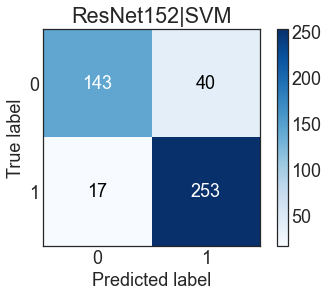

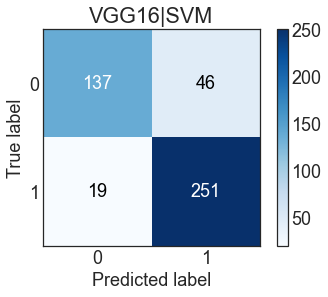

accuracy: {'ResNet152|SVM': 0.8741721854304636, 'VGG16|SVM': 0.8565121412803532}
sensitivity: {'ResNet152|SVM': 0.7814207650273224, 'VGG16|SVM': 0.7486338797814208}
specificity: {'ResNet152|SVM': 0.937037037037037, 'VGG16|SVM': 0.9296296296296296}
precision: {'ResNet152|SVM': 0.89375, 'VGG16|SVM': 0.8782051282051282}


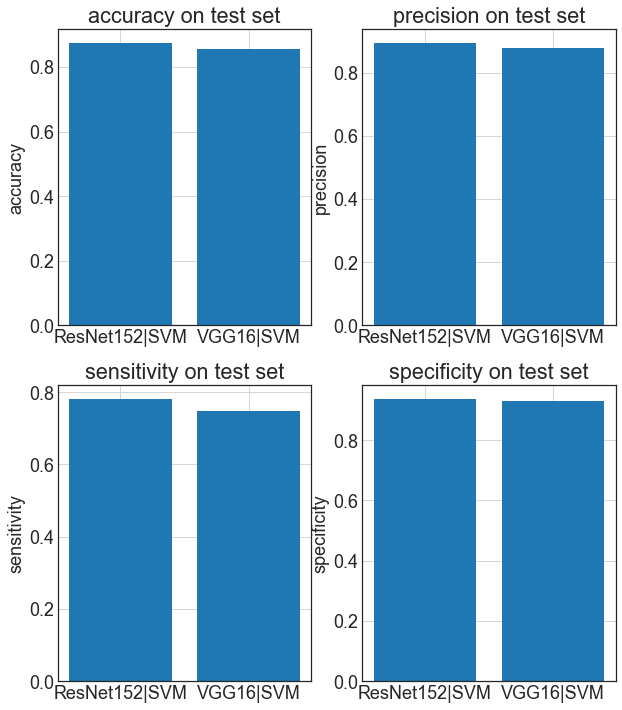

In [23]:
get_performance_measures([res_svm_clf, vgg_svm_clf], [res_X_test, vgg_X_test],
                         [res_y_test, vgg_y_test], ['ResNet152|SVM', 'VGG16|SVM'])

### KNN

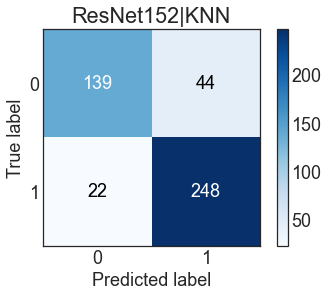

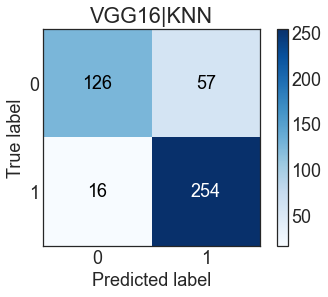

accuracy: {'ResNet152|KNN': 0.8543046357615894, 'VGG16|KNN': 0.8388520971302428}
sensitivity: {'ResNet152|KNN': 0.7595628415300546, 'VGG16|KNN': 0.6885245901639344}
specificity: {'ResNet152|KNN': 0.9185185185185185, 'VGG16|KNN': 0.9407407407407408}
precision: {'ResNet152|KNN': 0.8633540372670807, 'VGG16|KNN': 0.8873239436619719}


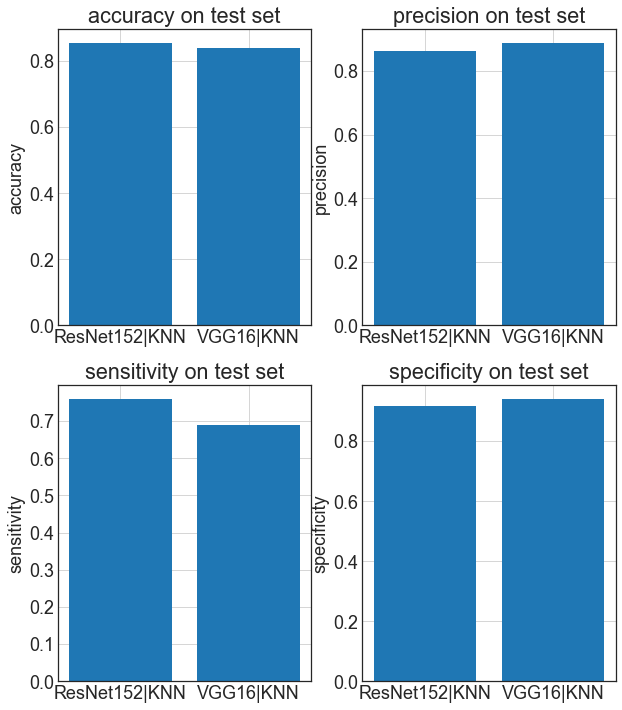

In [24]:
get_performance_measures([res_knn_clf, vgg_knn_clf], [res_X_test, vgg_X_test],
                         [res_y_test, vgg_y_test], ['ResNet152|KNN', 'VGG16|KNN'])

### Random Forest

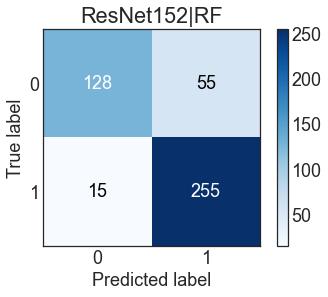

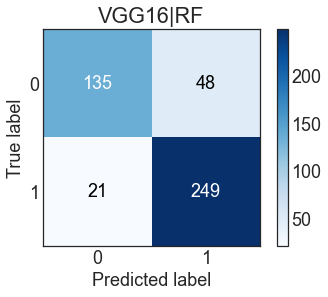

accuracy: {'ResNet152|RF': 0.8454746136865342, 'VGG16|RF': 0.847682119205298}
sensitivity: {'ResNet152|RF': 0.6994535519125683, 'VGG16|RF': 0.7377049180327869}
specificity: {'ResNet152|RF': 0.9444444444444444, 'VGG16|RF': 0.9222222222222223}
precision: {'ResNet152|RF': 0.8951048951048951, 'VGG16|RF': 0.8653846153846154}


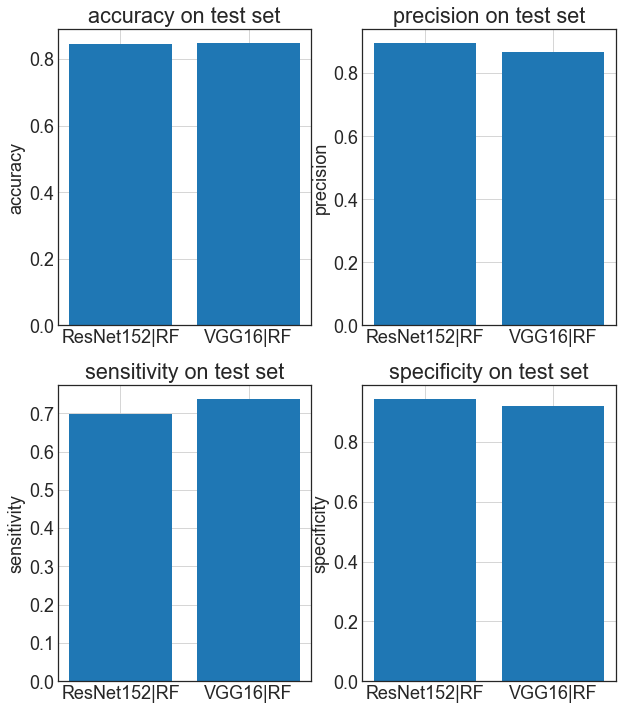

In [25]:
get_performance_measures([res_rf_clf, vgg_rf_clf], [res_X_test, vgg_X_test],
                         [res_y_test, vgg_y_test], ['ResNet152|RF', 'VGG16|RF'])

# References